Epoch 1/100
8/8 [==============================] - 6s 235ms/step - loss: 0.0762 - val_loss: 0.0048
Epoch 2/100
8/8 [==============================] - 1s 105ms/step - loss: 0.0179 - val_loss: 0.0047
Epoch 3/100
8/8 [==============================] - 1s 104ms/step - loss: 0.0104 - val_loss: 0.0047
Epoch 4/100
8/8 [==============================] - 1s 90ms/step - loss: 0.0079 - val_loss: 0.0046
Epoch 5/100
8/8 [==============================] - 1s 69ms/step - loss: 0.0069 - val_loss: 0.0049
Epoch 6/100
8/8 [==============================] - 1s 68ms/step - loss: 0.0072 - val_loss: 0.0053
Epoch 7/100
8/8 [==============================] - 1s 66ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 8/100
8/8 [==============================] - 1s 65ms/step - loss: 0.0066 - val_loss: 0.0058
Epoch 9/100
8/8 [==============================] - 1s 72ms/step - loss: 0.0066 - val_loss: 0.0051
Epoch 10/100
8/8 [==============================] - 1s 66ms/step - loss: 0.0072 - val_loss: 0.0058
Epoch 11/100
8/8

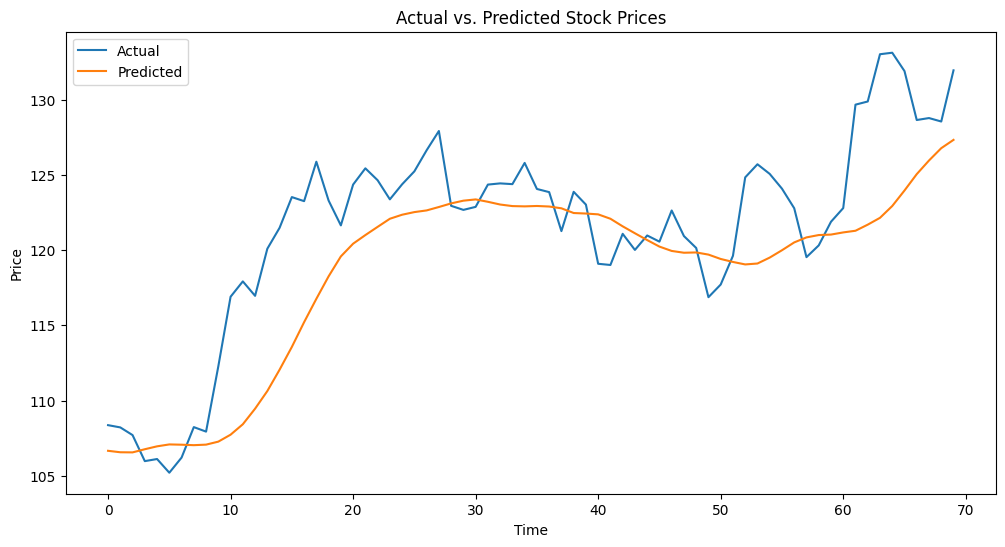

In [2]:
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Download data
goog = yf.Ticker("GOOG")
data = goog.history(start="2022-01-01", end="2023-08-08")

# Preprocess data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data["Close"].values.reshape(-1, 1))

timesteps = 10  # Define the number of time steps in each sequence

# Create sequences for training
def create_sequences(data, timesteps):
    sequences = []
    for i in range(len(data) - timesteps):
        sequences.append(data[i:i + timesteps])
    return np.array(sequences)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

train_sequences = create_sequences(train_data, timesteps)
train_targets = train_data[timesteps:]  # Target sequences need to be aligned

test_sequences = create_sequences(test_data, timesteps)
test_targets = test_data[timesteps:]  # Target sequences need to be aligned

# Build and train the model
model = Sequential()
model.add(LSTM(256, activation="tanh", return_sequences=True, input_shape=(timesteps, 1)))
model.add(Dropout(0.2))  # Add dropout layer to prevent overfitting
model.add(LSTM(128, activation="tanh"))
model.add(Dropout(0.2))  # Add dropout layer to prevent overfitting
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

# Implement early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(train_sequences, train_targets, epochs=100, validation_split=0.2, callbacks=[early_stopping])

# Make predictions
pred = model.predict(test_sequences)
pred = scaler.inverse_transform(pred)
test_true = scaler.inverse_transform(test_targets)

# Calculate RMSE
mse = np.mean(np.square(pred - test_true))
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_true, label="Actual")
plt.plot(pred, label="Predicted")
plt.title("Actual vs. Predicted Stock Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()
